# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patheffects as path_effects
from scipy.optimize import fsolve
import matplotlib.patheffects as pe
from scipy.stats import pearsonr
from collections import defaultdict
from scipy.ndimage import maximum_filter, generate_binary_structure

# Replication of Emergent Foraging Strategies under Resource Competition in MSA

## 3.1. Optimal Foraging of Individual Agent

### Heatmaps: $\epsilon(s, a\mid r)$ for $r\in{100, 200, 300}$

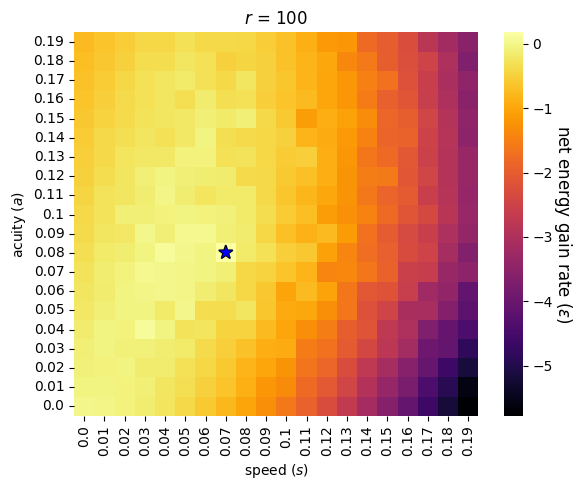

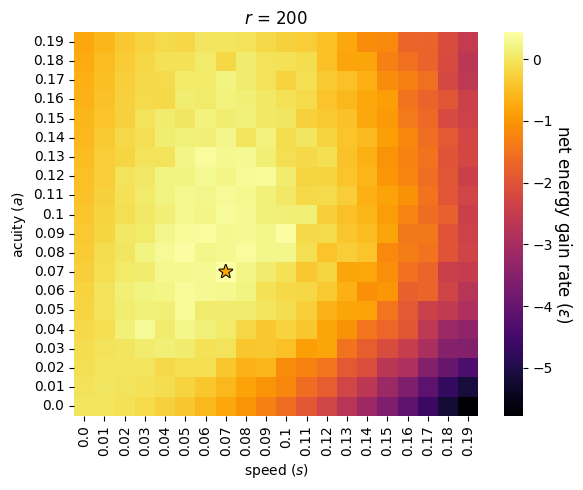

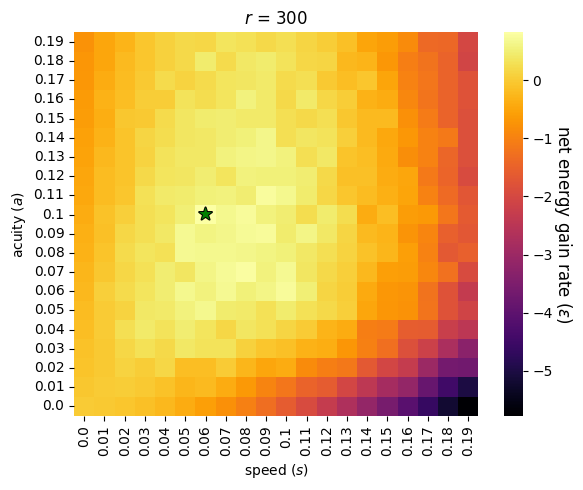

In [2]:
# Parameters
F = 1                # resource energy
c_s = 160
c_a = 4
steps = 1000         # number of steps
delta_t = 0.1        # time between steps
data_folder = "./simulation_results/"

# Colours for maximum values
star_colors = {
    100: "blue",
    200: "orange",
    300: "green"
}

# Load agent-level data
df = pd.read_csv(f"{data_folder}3_1_energy.csv", delimiter=",")
df = df.apply(pd.to_numeric, errors="coerce")

# epsilon = energy / time = energy / (steps * time between steps)
df["net_energy_gain_rate"] = df["energy"] / (steps * delta_t)

# Get sorted unique values of 'Rate'
r_values = sorted(df["Rate"].unique())

# Loop over each Rate value and create an independent figure
for r_value in r_values:
    # Filter data for current Rate value
    subset = df[df["Rate"] == r_value]

    # Create pivot table for heatmap
    pivot_table = subset.pivot_table(
        index='acuity',
        columns='speed',
        values='net_energy_gain_rate'
    )

    # Create a new figure for each plot
    plt.figure(figsize=(6, 5))

    # Create the heatmap
    heatmap = sns.heatmap(
        pivot_table,
        cmap="inferno",
        cbar=True
    )

    # Add colorbar and label
    cbar = heatmap.collections[0].colorbar
    cbar.set_label(r"net energy gain rate ($\varepsilon$)", rotation=-90, labelpad=15, fontsize=12)

    # Add title and axis labels
    plt.title(fr"$r$ = {int(r_value)}")
    plt.xlabel(r"speed ($s$)")
    plt.ylabel(r"acuity ($a$)")

    # Flip y-axis so that higher speed is at the top
    plt.gca().invert_yaxis()

    # Find maximum net energy gain rate
    max_val = pivot_table.max().max()

    # Find net energy gain rate maximizers
    max_coords = np.where(pivot_table == max_val)

    star_color = star_colors.get(r_value, "white")

    # Mark maximum in the heatmap
    for y_idx, x_idx in zip(*max_coords):
        text = plt.text(
            x=x_idx + 0.5,
            y=y_idx + 0.5,
            s="★",
            color=star_color,
            ha='center',
            va='center',
            fontsize=12,
            fontweight='bold'
        )
        
        # Add back contour
        text.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()
        ])

    # Display the figure
    plt.tight_layout()
    plt.show()


### Plot $\mathcal{L}(a\mid r)$ vs $a$

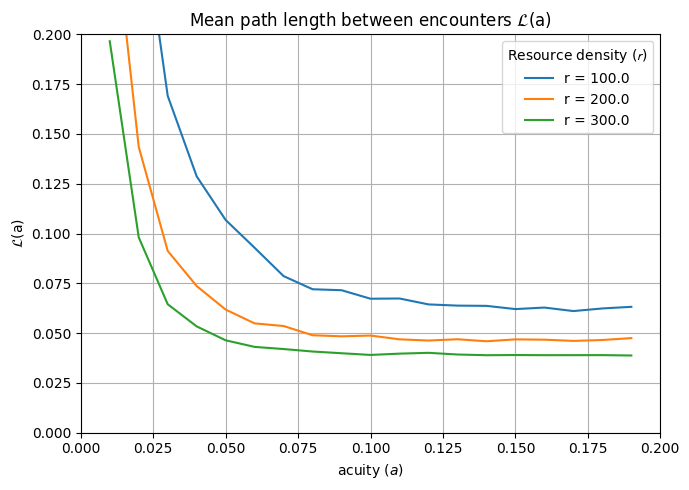

In [3]:
# C = c_s * s^2 + c_a * a
df["metabolic_cost"] = c_s * df["speed"]**2 + c_a * df["acuity"]

# ni = (epsilon + C) / F
df["resources_per_time"] = (df["net_energy_gain_rate"] + df["metabolic_cost"]) / F

# Compute mean path length between encounters
with np.errstate(divide='ignore', invalid='ignore'):
    df["L"] = df["speed"] / df["resources_per_time"]

df = df[(df["L"] >= 1e-5) & (df["L"] <= 1e5)]

# Plot 𝓛(a) vs. acuity for each resource density r
plt.figure(figsize=(7, 5))

# Loop over each Rate
for r_value in sorted(df["Rate"].unique()):
    subset = df[df["Rate"] == r_value]


    # Group by acuity and calculate mean L (if needed)
    grouped = subset.groupby("acuity")["L"].mean().reset_index()

    # Plot line
    plt.plot(grouped["acuity"], grouped["L"], label=f"r = {r_value}")

# Labels and title
plt.xlabel(r"acuity ($a$)")
plt.ylabel(r"$\mathcal{L}($a$)$")
plt.title(r"Mean path length between encounters $\mathcal{L}($a$)$")
plt.legend(title=r"Resource density ($\mathcal{r}$)")
plt.xlim(0,0.2)
plt.ylim(0,0.2)
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot $\frac{d}{da}[g^2(a\mid r)]$ vs $a$

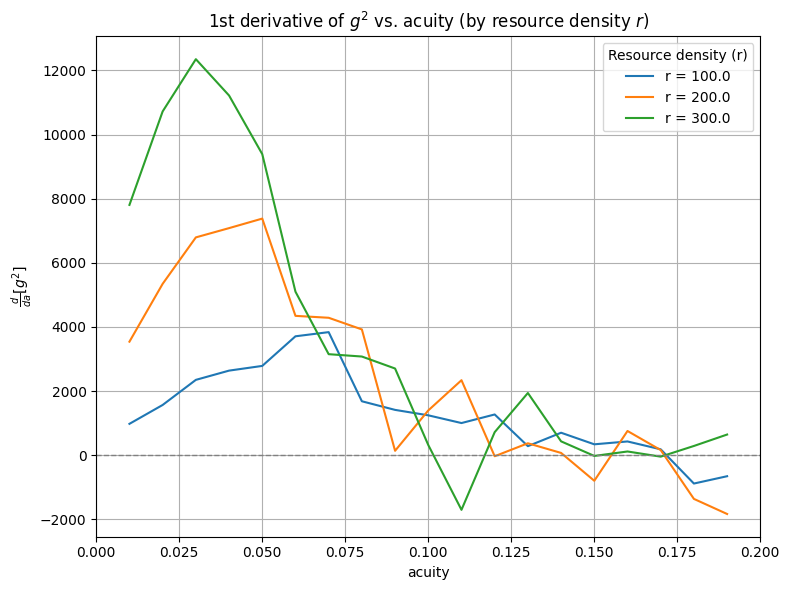

In [4]:
df = df.dropna(subset=["L"])
plt.figure(figsize=(8, 6))

# Loop through each resource density r
for r_value in sorted(df["Rate"].unique()):
    # Filter and sort by acuity
    subset = df[df["Rate"] == r_value]

    # Group by acuity and calculate mean L
    grouped = subset.groupby("acuity")["L"].mean().reset_index()
    a = grouped["acuity"].values
    L = grouped["L"].values
    
    with np.errstate(divide='ignore', invalid='ignore'):
        g = 1 / L
        g2 = g**2
        # Compute gradient pf g2 w.r.t. a
        dg2_da = np.gradient(g2, a)

    # Plot the derivative curve for this r
    plt.plot(a, dg2_da, label=f"r = {r_value}")

# Add horizontal dashed line at y=0 (without duplicate label)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Labels and layout
plt.xlabel("acuity")
plt.ylabel(r"$\frac{d}{da}[g^2]$")
plt.title("1st derivative of $g^2$ vs. acuity (by resource density $r$)")
plt.xlim(0, 0.2)
#plt.ylim(-1e4, 4e4)
plt.grid(True)
plt.legend(title="Resource density (r)")
plt.tight_layout()
plt.show()


## 3.2. Steady-State of a Population Using Single Strategy

### Heatmaps: $log_{10}(n*)$ and $log_{10}(N)$

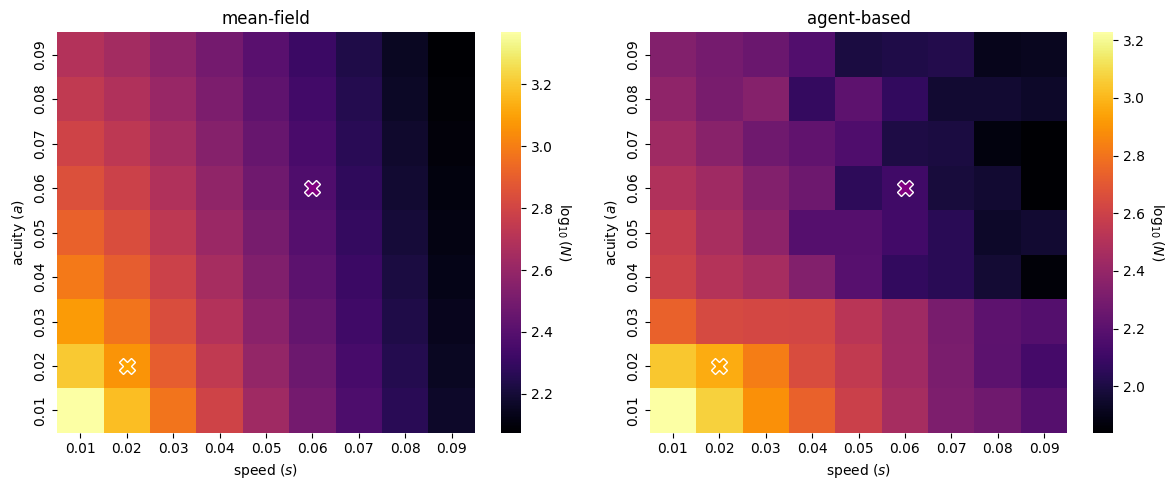

In [5]:
# Parameters 
alpha = 4
beta = 1
delta_0 = 5e-3
delta = 1
K_b = 10
K_d = 1.0
F = 200
resource_generation_rate = 1

# Function that represents b(E) - d(E)
def f(E):
    E_alpha = E**alpha
    b = beta * (E_alpha / (E_alpha + K_b**alpha))
    d = delta_0 + delta * (K_d**alpha / (E_alpha + K_d**alpha))
    return b - d

initial_guess = 1.0

# Solve b(E) = d(E) to obtain E*
E_star = fsolve(f, initial_guess)[0]
E_alpha = E_star**alpha

# Load agent-level data
df = pd.read_csv(f"{data_folder}3_2_1000Steps_500pop.csv", delimiter=",")
df = df.apply(pd.to_numeric, errors="coerce")
df[["acuity", "speed"]] = df[["acuity", "speed"]].round(2)

# Mean-field computation
df["metabolic_cost"] = c_s * df["speed"]**2 + c_a * df["acuity"]
df["birth_rate"] = beta * E_alpha / (E_alpha + K_b**alpha)
df["n*"] = resource_generation_rate * F / (df["metabolic_cost"] + df["birth_rate"] * np.log(2) * E_star)
df["log_10_n*"] = np.log10(df["n*"])

# Agent-based log10 population
df["log10_N"] = np.log10(df["population"])

# Create pivot tables
pivot_meanfield = df.pivot_table(index='acuity', columns='speed', values='log_10_n*')
pivot_agentbased = df.pivot_table(index='acuity', columns='speed', values='log10_N')

# Get positions (row index and column index) for the specific acuity/speed pairs
def get_heatmap_coords(pivot_table, acuity_val, speed_val):
    row = np.where(pivot_table.index == acuity_val)[0][0]
    col = np.where(pivot_table.columns == speed_val)[0][0]
    return col + 0.5, row + 0.5  # shift by 0.5 to center the marker in the heatmap cell

# Coordinates for the two points
x1, y1 = get_heatmap_coords(pivot_meanfield, 0.02, 0.02)
x2, y2 = get_heatmap_coords(pivot_meanfield, 0.06, 0.06)

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Mean-field
sns.heatmap(pivot_meanfield, cmap="inferno", cbar=True, ax=axs[0])
axs[0].set_title("mean-field")
axs[0].set_xlabel(r"speed ($s$)")
axs[0].set_ylabel(r"acuity ($a$)")
axs[0].invert_yaxis()
axs[0].collections[0].colorbar.set_label(r"$\log_{10}(N)$", rotation=-90, labelpad=15)

# Mark points on mean-field
axs[0].plot(x1, y1, marker='X', color='orange', markersize=12, markeredgecolor='white')
axs[0].plot(x2, y2, marker='X', color='purple', markersize=12, markeredgecolor='white')

# Agent-based
sns.heatmap(pivot_agentbased, cmap="inferno", cbar=True, ax=axs[1])
axs[1].set_title("agent-based")
axs[1].set_xlabel(r"speed ($s$)")
axs[1].set_ylabel(r"acuity ($a$)")
axs[1].invert_yaxis()
axs[1].collections[0].colorbar.set_label(r"$\log_{10}(N)$", rotation=-90, labelpad=15)

# Mark points on agent-based
axs[1].plot(x1, y1, marker='X', color='orange', markersize=12, markeredgecolor='white')
axs[1].plot(x2, y2, marker='X', color='purple', markersize=12, markeredgecolor='white')

plt.tight_layout()
plt.show()

### Plots: Convergence to steady-state population

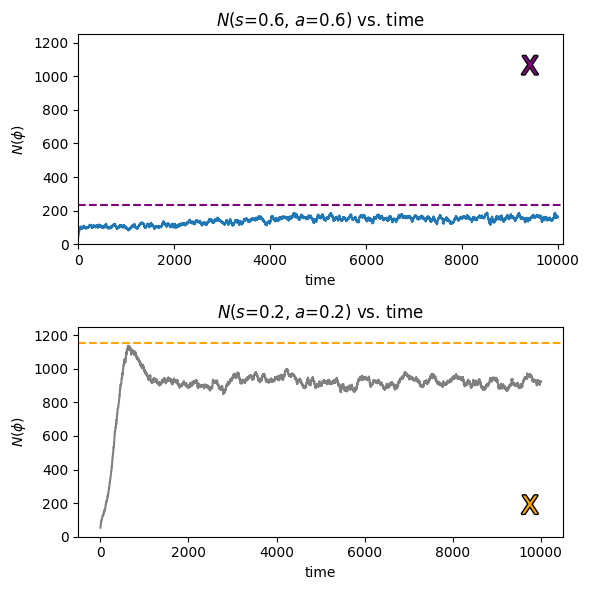

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Load data from CSV file for speed=0.02 and acuity=0.02
df1 = pd.read_csv(f"{data_folder}pop_0.02_0.02.csv", delimiter=",")
df1 = df1.apply(pd.to_numeric, errors="coerce")
# Extract the "n*" value from dataframe df where speed and acuity are close to 0.02
N1 = df[np.isclose(df["speed"], 0.02) & np.isclose(df["acuity"], 0.02)]["n*"].values

axs[1].plot(df1["step"], df1["population"], color="grey")
axs[1].set_xlabel("time")
axs[1].set_ylabel(r"$N(\phi)$")
axs[0].set_xlim(0, 10100)
axs[1].set_ylim(0, 1250)
axs[1].set_title(r"$N$($s$=0.2, $a$=0.2) vs. time")
# Add dashed orange line (asymptote) at y = N1
line = axs[1].axhline(y=N1, color='orange', linestyle='--')
star_text = axs[1].text(0.95, 0.2, "X", transform=axs[1].transAxes,
                       fontsize=18, color="orange", ha="right", va="top")
star_text.set_path_effects([
    path_effects.Stroke(linewidth=2, foreground='black'),
    path_effects.Normal()
])


# Load data from CSV for speed=0.06 and acuity=0.06
df2 = pd.read_csv(f"{data_folder}pop_0.06_0.06.csv", delimiter=",")
df2 = df2.apply(pd.to_numeric, errors="coerce")
# Extract "n*" value for speed=0.06 and acuity=0.06
N2 = df[np.isclose(df["speed"], 0.06) & np.isclose(df["acuity"], 0.06)]["n*"].values

axs[0].plot(df2["step"], df2["population"])
axs[0].set_xlabel("time")
axs[0].set_ylabel(r"$N(\phi)$")
axs[0].set_xlim(0, 10100)
axs[0].set_ylim(0, 1250)
axs[0].set_title(r"$N$($s$=0.6, $a$=0.6) vs. time")
# Add dashed purple line (asymptote) at y = N2
line = axs[0].axhline(y=N2, color='purple', linestyle='--')
star_text2 = axs[0].text(0.95, 0.9, "X", transform=axs[0].transAxes,
                        fontsize=18, color="purple", ha="right", va="top")
star_text2.set_path_effects([
    path_effects.Stroke(linewidth=2, foreground='black'),
    path_effects.Normal()
])

plt.tight_layout()
plt.show()

## 3.3. Selection Between Strategies with the Same Metabolic Cost

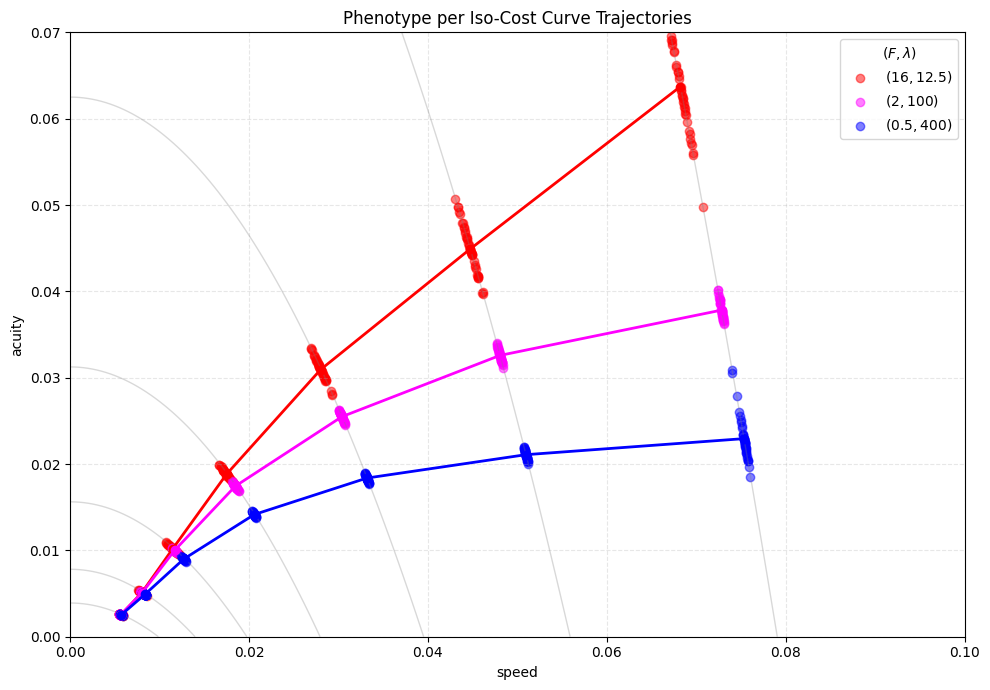

In [7]:
# Load the data
df = pd.read_csv(f"{data_folder}3_3_envParam3_cost7_simulations40.csv", delimiter=",")

# Compute isocost values
df["isocost_curve"] = c_s * df["speed"]**2 + c_a * df["acuity"]
df["isocost_curve"] = df["isocost_curve"].round(5)

# Define the (F, λ) pairs
target_conditions = [
    (16, 12.5),
    (2, 100),
    (0.5, 400)
]

labels = [r"$(16, 12.5)$", r"$(2, 100)$", r"$(0.5, 400)$"]
colors = ['red', 'magenta', 'blue']

plt.figure(figsize=(10, 7))

# === Draw gray isocost curves ===
speed_grid = np.linspace(0, 0.1, 200)
acuity_grid = np.linspace(0, 0.07, 200)
S, A = np.meshgrid(speed_grid, acuity_grid)
isocost_grid = c_s * S**2 + c_a * A

# Use only the unique isocost values from the dataset
levels = np.sort(df["isocost_curve"].unique())
plt.contour(S, A, isocost_grid, levels=levels, colors='gray', alpha=0.3, linewidths=1)

# === Plot simulation means and average trajectory ===
for (F, lam), label, color in zip(target_conditions, labels, colors):
    env_df = df[(df["F"] == F) & (df["Lamb"] == lam)]

    # Mean point per simulation and isocost
    sim_means = (
        env_df
        .groupby(["Simulation", "isocost_curve"])[["speed", "acuity"]]
        .mean()
        .reset_index()
    )

    # Scatter individual simulation means
    plt.scatter(sim_means["speed"], sim_means["acuity"], color=color, alpha=0.5, label=label)

    # Mean across simulations per isocost level
    overall_mean = (
        sim_means
        .groupby("isocost_curve")[["speed", "acuity"]]
        .mean()
        .reset_index()
        .sort_values("isocost_curve")
    )

    # Draw line connecting the average phenotype per isocost
    plt.plot(overall_mean["speed"], overall_mean["acuity"], color=color, marker='o', linewidth=2)

# Plot formatting
plt.xlabel("speed")
plt.ylabel("acuity")
plt.title("Phenotype per Iso-Cost Curve Trajectories")
plt.xlim(0, 0.1)
plt.ylim(0, 0.07)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title=r'$(F, \lambda)$')
plt.tight_layout()
plt.show()


## 3.4. Coexistence of Phenotypic Attributes

### Heatmaps: $N(s,a\mid \lambda)$

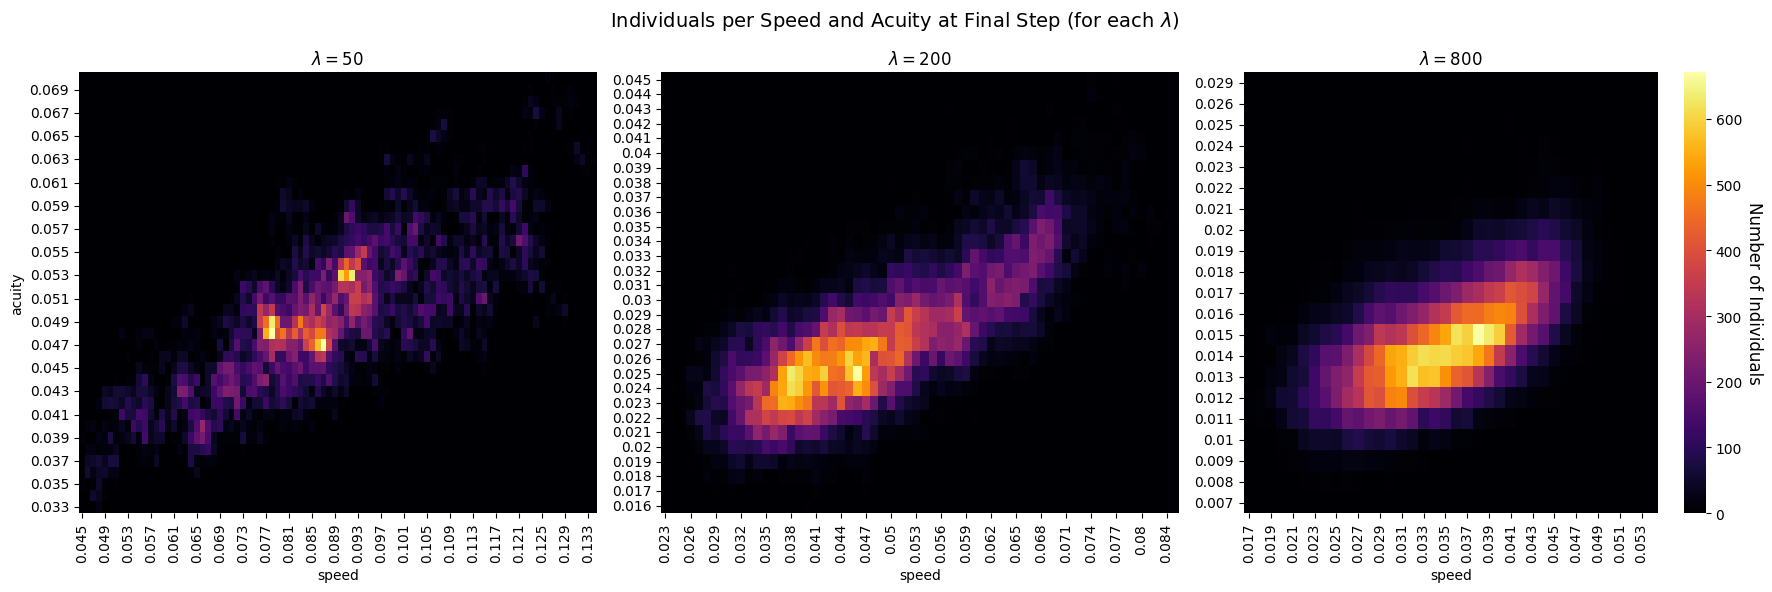

In [40]:
# List of your CSV files
files_3_4 = f"{data_folder}3_4_envParam3_simulations"
files = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80"]
files = [f"{files_3_4}{file}.csv" for file in files]

# Read and concatenate all CSVs
df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# Parameters
lambdas = [int(resource_density) for resource_density in df["Lamb"].unique()]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, lam in enumerate(lambdas):
    df_lam = df[df["Lamb"] == lam]

    # Get only the rows corresponding to the last step of each simulation
    max_steps = df_lam.groupby("Simulation")["step"].transform("max")
    df_heatmap = df_lam[df_lam["step"] == max_steps].copy()

    # Round for consistent binning
    df_heatmap["speed"] = df_heatmap["speed"].round(3)
    df_heatmap["acuity"] = df_heatmap["acuity"].round(3)

    # Count individuals per (speed, acuity) pair
    count_data = df_heatmap.groupby(["speed", "acuity"]).size().reset_index(name="count")

    # Pivot to heatmap format
    heatmap_data = count_data.pivot(index="acuity", columns="speed", values="count").fillna(0)

    # Plot heatmap
    ax = axes[i]
    sns.heatmap(heatmap_data, cmap="inferno", ax=ax, cbar=(i == 2))

    # Axis and title
    ax.set_title(rf"$\lambda = {lam}$")
    ax.set_xlabel("speed")
    if i == 0:
        ax.set_ylabel("acuity")
    else:
        ax.set_ylabel("")

    ax.invert_yaxis()

# Add single colorbar for the last heatmap
cbar = axes[2].collections[0].colorbar
cbar.set_label("Number of Individuals", rotation=-90, labelpad=15, fontsize=12)

plt.suptitle(r"Individuals per Speed and Acuity at Final Step (for each $\lambda$)", fontsize=14)
plt.tight_layout()
plt.show()


### Heatmap: $N(s,$ generation $)$

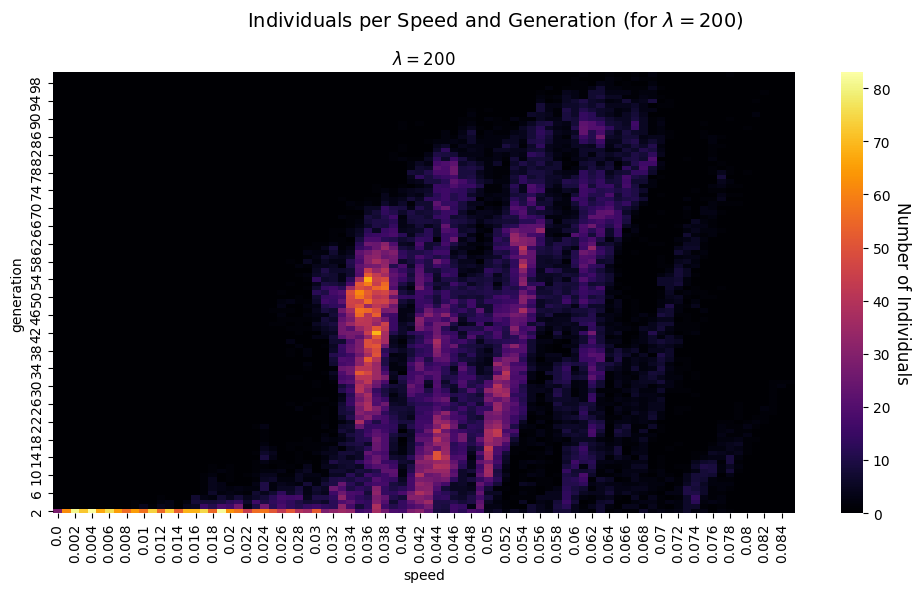

In [12]:
df_200 = df[df["Lamb"] == 200]
df_200 = df_200[df_200["gen"] > 1]
# Keep only one row per unique ID
df_200 = df_200.drop_duplicates(subset="id")

# Round for consistent binning
df_200["speed"] = df_200["speed"].round(3)

# Count individuals per (speed, generation) pair
count_data = df_200.groupby(["gen", "speed"]).size().reset_index(name="count")

# Pivot to heatmap format (rows = gen, cols = speed)
heatmap_data = count_data.pivot(index="gen", columns="speed", values="count").fillna(0)

# Plot heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data, cmap="inferno")

# Axis and title
ax.set_title(r"$\lambda = 200$")
ax.set_xlabel("speed")
ax.set_ylabel("generation")
ax.invert_yaxis()

# Add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label("Number of Individuals", rotation=-90, labelpad=15, fontsize=12)

plt.suptitle(r"Individuals per Speed and Generation (for $\lambda = 200$)", fontsize=14)
plt.tight_layout()
plt.show()


### Plot: $\rho(s,a \mid \lambda)$

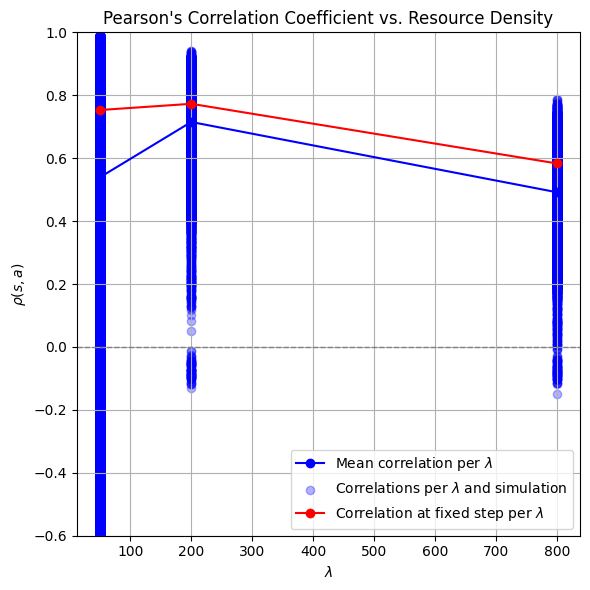

In [79]:
# --- Step 1: Calculate correlations grouped by 'Lamb', 'Simulation', and 'step' ---
# Store correlations per lambda and step, list of correlations per simulation
corrs_per_lambda_step_sim = defaultdict(lambda: defaultdict(list))

for (lamb, sim, step), group in df.groupby(["Lamb", "Simulation", "step"]):
    if group.shape[0] > 1:  # Need at least 2 data points for correlation
        corr, _ = pearsonr(group["speed"], group["acuity"])
        corrs_per_lambda_step_sim[lamb][step].append(corr)
    else:
        corrs_per_lambda_step_sim[lamb][step].append(np.nan)

# Sort lambdas to keep order consistent
sorted_lambdas_sim = sorted(corrs_per_lambda_step_sim.keys())

# Compute mean correlation across all steps and simulations for each lambda
mean_corrs_sim = []
for lamb in sorted_lambdas_sim:
    all_corrs = []
    for step_corrs in corrs_per_lambda_step_sim[lamb].values():
        all_corrs.extend(step_corrs)  # Flatten list of correlations
    mean_corrs_sim.append(np.nanmean(all_corrs))

# --- Substitute fixed step by last timestep per simulation ---

# 1. For each (Lamb, Simulation) pair, find the maximum step (i.e., last timestep)
last_steps = df.groupby(["Lamb", "Simulation"])["step"].max().reset_index()

# 2. Merge with original dataframe to filter only rows corresponding to the last timestep of each simulation
df_last_steps = pd.merge(df, last_steps, on=["Lamb", "Simulation", "step"])

# 3. Group by 'Lamb' and compute correlation between 'speed' and 'acuity' using data from last timesteps of simulations
corrs_per_lambda_fixed = {}
for lamb, group in df_last_steps.groupby("Lamb"):
    if group.shape[0] > 1:  # Need at least 2 data points for correlation
        corr, _ = pearsonr(group["speed"], group["acuity"])
        corrs_per_lambda_fixed[lamb] = corr
    else:
        corrs_per_lambda_fixed[lamb] = np.nan  # Not enough data points

# Sort lambdas and corresponding correlations for consistent plotting
sorted_lambdas_fixed = sorted(corrs_per_lambda_fixed.keys())
sorted_corrs_fixed = [corrs_per_lambda_fixed[l] for l in sorted_lambdas_fixed]

# --- Step 3: Plot all results on the same figure ---

plt.figure(figsize=(6, 6))

# Plot 1: Mean correlation per lambda across all simulations (blue solid line with circles)
plt.plot(sorted_lambdas_sim, mean_corrs_sim, marker='o', linestyle='-', color='blue', label=r'Mean correlation per $\lambda$')

# Plot 2: Individual correlations per simulation (blue scatter points with transparency)
for lamb in sorted_lambdas_sim:
    all_corrs = []
    for step_corrs in corrs_per_lambda_step_sim[lamb].values():
        all_corrs.extend(step_corrs)
    x = [lamb] * len(all_corrs)
    plt.scatter(x, all_corrs, color='blue', alpha=0.3, label=r'Correlations per $\lambda$ and simulation' if lamb == sorted_lambdas_sim[0] else "")

# Plot 3: Correlation at the last timestep per simulation for each lambda (red dashed line with square markers)
plt.plot(sorted_lambdas_fixed, sorted_corrs_fixed, marker='o', linestyle='-', color='red', label=r'Correlation at fixed step per $\lambda$')

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel(r'$\lambda$')
plt.ylabel(r"$\rho (s, a)$")
plt.title("Pearson's Correlation Coefficient vs. Resource Density")
plt.ylim(-0.6, 1)

# Add legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the combined plot
plt.show()


# Selection of different strategies represented by different agent species

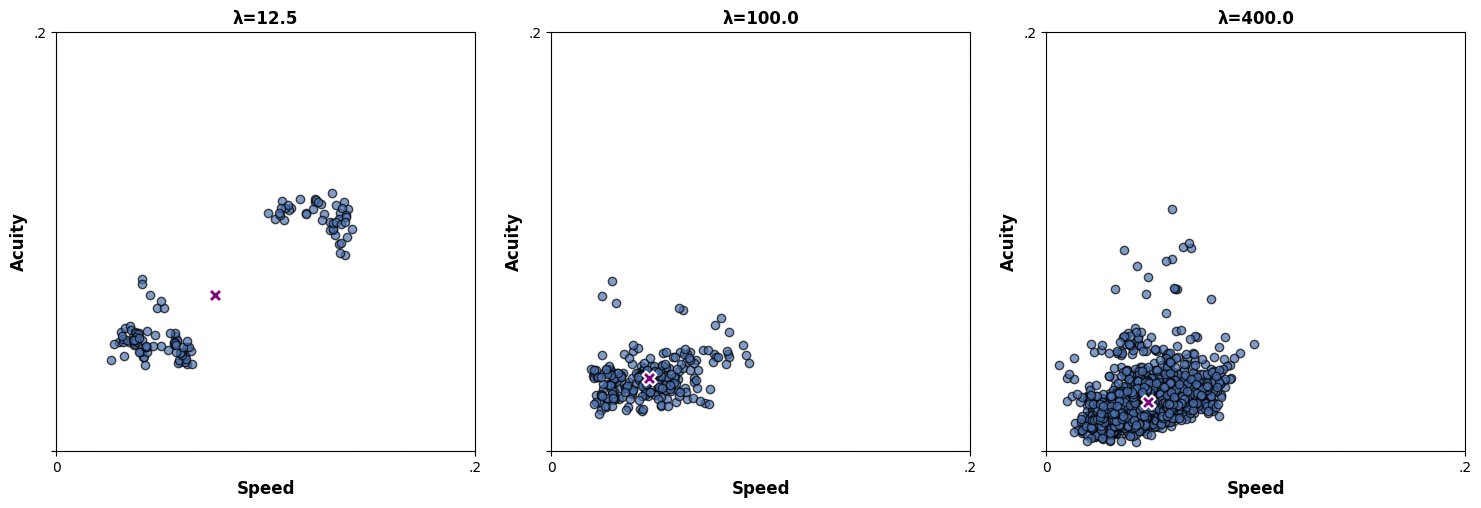

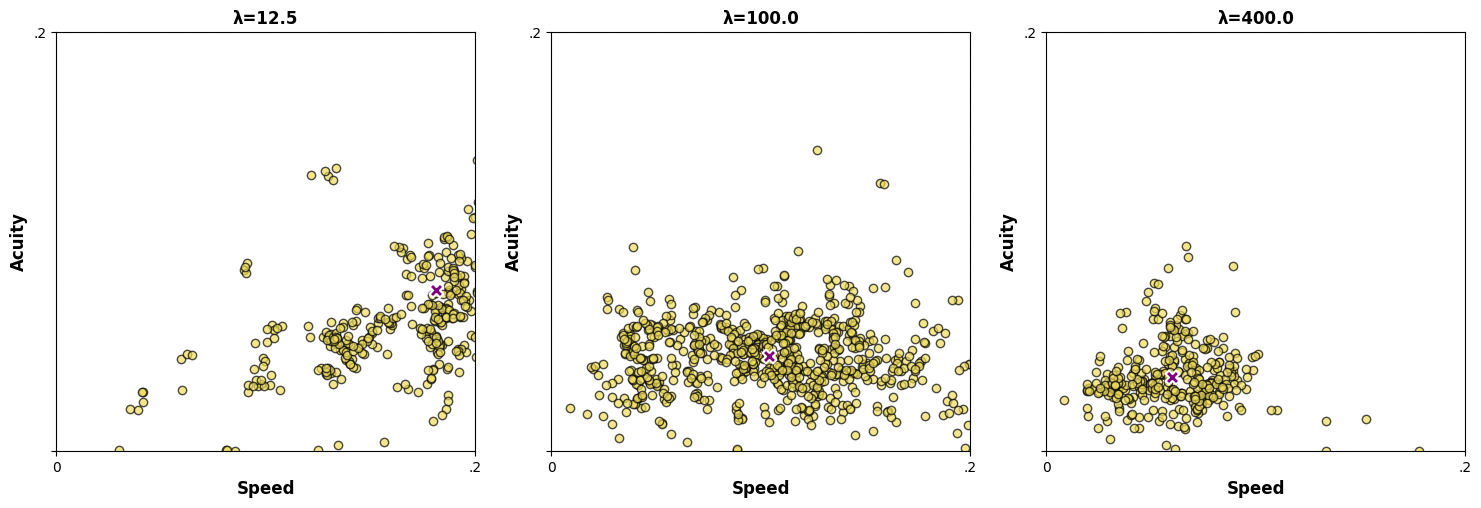

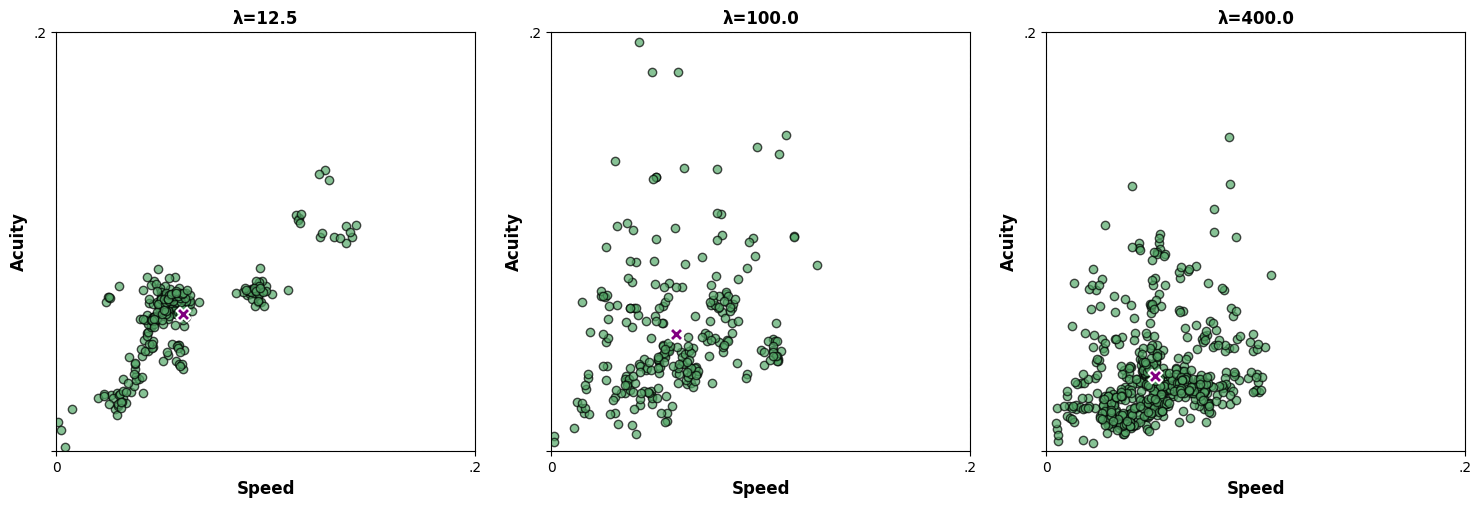

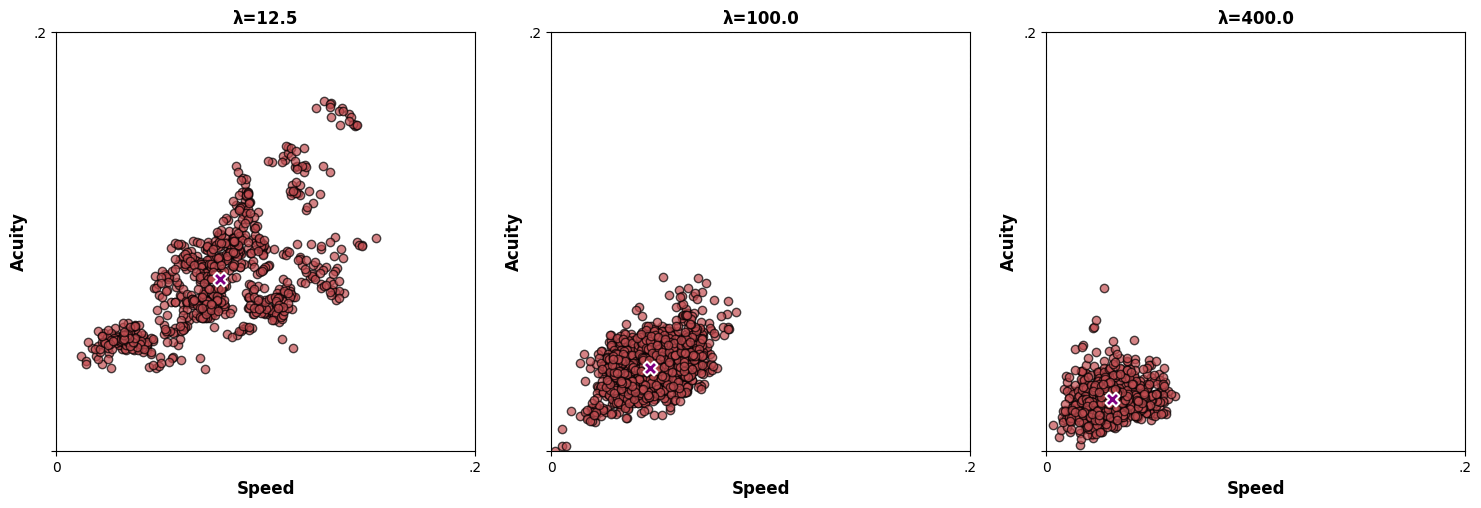

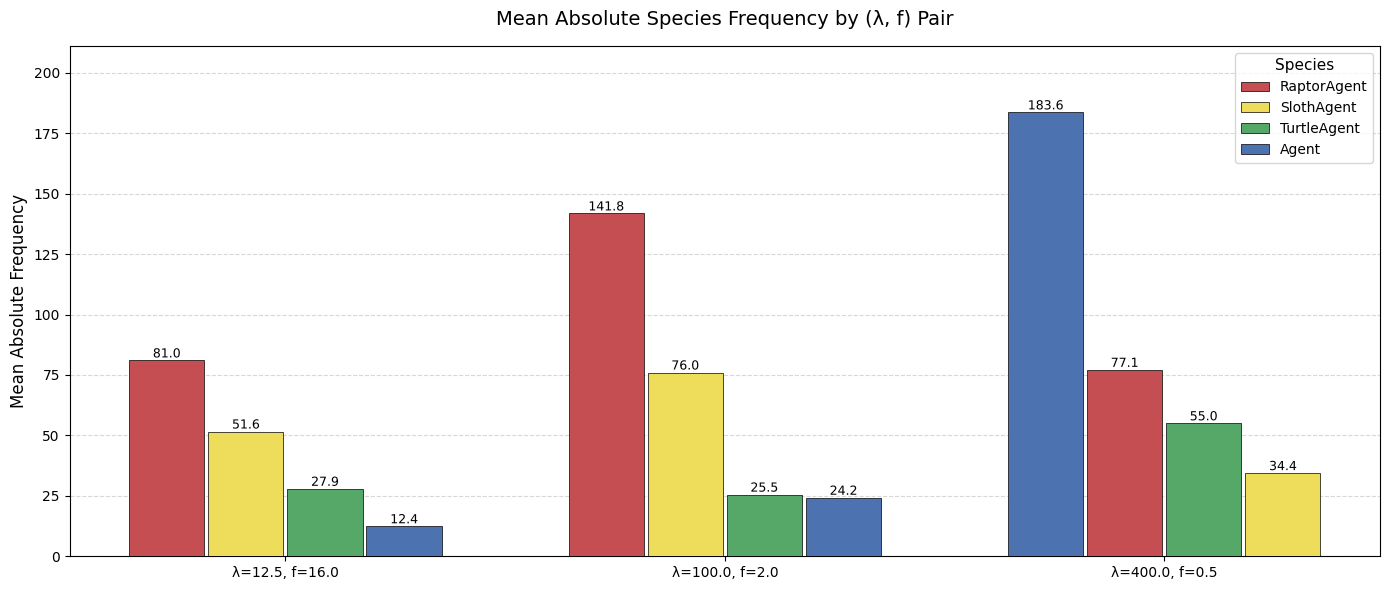

In [30]:

# Load the CSV
df = pd.read_csv("simulation_results/speciesResults.csv")

# ----------------------------------------
# Shared Configuration
# ----------------------------------------

species_colors = {
    'Agent': '#4C72B0',        # blue
    'SlothAgent': '#EEDC5B',   # yellow
    'TurtleAgent': '#55A868',  # green
    'RaptorAgent': '#C44E52'   # red
}
species_list = ['Agent', 'SlothAgent', 'TurtleAgent', 'RaptorAgent']

# Create (lambda, f) column for grouping
df['lambda_f'] = list(zip(df['lambda'], df['f']))

# ----------------------------------------
# Scatterplots: Grouped by Species
# ----------------------------------------

unique_pairs = df[['lambda', 'f']].drop_duplicates().reset_index(drop=True)

for species in species_list:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    for i, (lam, f_val) in unique_pairs.iterrows():
        if i >= 3:
            break  # Only show first 3 (λ, f) pairs

        ax = axes[i]
        subset = df[
            (df['lambda'] == lam) &
            (df['f'] == f_val) &
            (df['species'] == species)
        ]

        if not subset.empty:
            ax.scatter(
                subset['speed'], subset['acuity'],
                color=species_colors.get(species, 'black'),
                alpha=0.7,
                edgecolors='k'
            )

            # Mean marker
            mean_speed = subset['speed'].mean()
            mean_acuity = subset['acuity'].mean()
            ax.scatter(
                mean_speed, mean_acuity,
                color='purple',      
                marker='X',          
                s=100,               
                edgecolors='white',
                linewidth=1.5,
                zorder=5
            )
        else:
            ax.text(0.1, 0.1, 'No Data', ha='center', va='center', fontsize=10, color='gray')

        ax.set_title(f'λ={lam}', fontweight='bold')
        ax.set_xlim(0, 0.2)
        ax.set_ylim(0, 0.2)
        ax.set_xticks([0, 0.2])
        ax.set_yticks([0, 0.2])
        ax.set_xticklabels(['0', '.2'])
        ax.set_yticklabels(['', '.2'])
        ax.set_xlabel('Speed', fontsize=12, fontweight='bold')
        ax.set_ylabel('Acuity', fontsize=12, fontweight='bold')
        ax.set_aspect('equal')
        ax.grid(True, linestyle='--', alpha=0.5)

    for j in range(len(unique_pairs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ----------------------------------------
# Mean Absolute Frequency Bar Plot
# ----------------------------------------

# Compute mean absolute frequency
freq = df.groupby(['lambda_f', 'species']).size().reset_index(name='mean_freq')
freq['mean_freq'] /= 10  # Normalize (e.g., 10 simulation runs)

# Prepare plot
pairs = sorted(freq['lambda_f'].unique(), key=lambda x: (x[0], x[1]))
x_locs = np.arange(len(pairs))
bar_width = 0.18

fig, ax = plt.subplots(figsize=(14, 6))

for i, pair in enumerate(pairs):
    subset = freq[freq['lambda_f'] == pair].sort_values('mean_freq', ascending=False).reset_index(drop=True)
    for j, row in subset.iterrows():
        species = row['species']
        value = row['mean_freq']
        offset = (j - 1.5) * bar_width

        bar = ax.bar(
            x_locs[i] + offset,
            value,
            width=bar_width * 0.95,
            color=species_colors[species],
            edgecolor='black',
            linewidth=0.5,
            label=species if i == 0 else "",
            zorder=3
        )

        # Add text label
        ax.text(
            x_locs[i] + offset,
            value + 0.01,
            f'{value:.1f}',
            ha='center',
            va='bottom',
            fontsize=9,
            color='black',
            path_effects=[pe.withStroke(linewidth=1, foreground='white')]
        )

# Aesthetics
ax.set_title('Mean Absolute Species Frequency by (λ, f) Pair', fontsize=14, pad=15)
ax.set_ylabel('Mean Absolute Frequency', fontsize=12)
ax.set_xticks(x_locs)
ax.set_xticklabels([f'λ={p[0]}, f={p[1]}' for p in pairs], fontsize=10)
ax.set_ylim(0, freq['mean_freq'].max() * 1.15)
ax.legend(title='Species', fontsize=10, title_fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()
